In [1]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys

In [2]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:

env = gym.make('CartPole-v0')
seed = 0
env.reset(seed=seed)

c:\Users\Noé\Documents\EPFL\RL\project\RLHF_EGGang\.venv\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


(array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32),
 {})

In [5]:
class Policy(nn.Module): # definie the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

# Generate $\pi_1$ and $\pi_2$ using REINFORCE

In [6]:
# REINFORCE (with reward-to-go)
# --> with gradient estimator according to version 2 of the PG theorem (not using Q-values, but reward to go)
def reinforce_rwd2go(policy, optimizer, seed, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset(seed=seed)
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, truncated, info = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G = rewards_to_go[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [7]:
def naive_baseline(state): # Example Baseline from lecture 4 (for inspiration)
  angle = state[2]
  value = 100*(0.25-angle**2) # TO BE CHANGED USING YOUR BASELINE
  return value

def baseline_1(state): # TO BE CHANGED USING YOUR BASELINE 1
  cart_position = state[0]   # TODO
  cart_velocity = state[1]
  angle = state[2]
  angular_velocity = state[3]

  value = - 10*np.abs(angle/0.2) - 0.5*np.abs(angular_velocity)

  return value # TODO

def baseline_2(state): # TO BE CHANGED USING YOUR BASELINE 2
  cart_position = state[0]   # TODO
  cart_velocity = state[1]
  angle = state[2]
  angular_velocity = state[3]

  value = - 10*np.abs(angle/0.2) - 0.5*np.abs(cart_position/2)
  return value # TODO

# PLOT 3: reward-to-go with baseline REINFORCE
# --> with gradient estimator according to version 3 of the PG theorem (not using Q-values, but reward to go)
# --> here, we consider only fixed (handcrafted) baseline functions b : S -> R; clearly, training a NN to predict V^{\pi}(s) as a baseline is also possible (and interesting!)
def reinforce_rwd2go_baseline(policy, optimizer, seed, early_stop=False, baseline=naive_baseline, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        baseline_values = []
        state,_ = env.reset(seed=seed)
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, truncated, info = env.step(action)
            rewards.append(reward)
            baseline_values.append(baseline(state))
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G_centered = rewards_to_go[i] - baseline_values[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G_centered)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [9]:
np.bool8 = bool
# PLOT 2: run REINFORCE and YOUR baseline 1
policy_baseline_1 = Policy().to(device)
optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, seed=seed, baseline=baseline_1, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')

# PLOT 3: run REINFORCE and YOUR baseline 2
policy_baseline_2 = Policy().to(device)
optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)
scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, seed=seed, baseline=baseline_2, early_stop=False, n_episodes=2000)


Episode 100	Average Score: 44.43
Episode 200	Average Score: 85.45
Episode 300	Average Score: 88.54
Episode 400	Average Score: 120.80
Episode 500	Average Score: 25.37
Episode 600	Average Score: 52.17
Episode 700	Average Score: 154.13
Episode 800	Average Score: 228.47
Episode 900	Average Score: 184.87
Episode 1000	Average Score: 150.76
Episode 1100	Average Score: 305.21
Episode 1200	Average Score: 416.10
Episode 1300	Average Score: 925.54
Episode 1400	Average Score: 1000.00
Episode 1500	Average Score: 938.77
Episode 1600	Average Score: 1000.00
Episode 1700	Average Score: 579.55
Episode 1800	Average Score: 469.67
Episode 1900	Average Score: 93.96


c:\Users\Noé\Documents\EPFL\RL\project\RLHF_EGGang\.venv\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Episode 100	Average Score: 45.48
Episode 200	Average Score: 82.16
Episode 300	Average Score: 173.23
Episode 400	Average Score: 97.95
Episode 500	Average Score: 99.02
Episode 600	Average Score: 298.86
Episode 700	Average Score: 118.90
Episode 800	Average Score: 9.51
Episode 900	Average Score: 9.51
Episode 1000	Average Score: 9.51
Episode 1100	Average Score: 9.77
Episode 1200	Average Score: 9.89
Episode 1300	Average Score: 10.02
Episode 1400	Average Score: 10.02
Episode 1500	Average Score: 10.19
Episode 1600	Average Score: 10.18
Episode 1700	Average Score: 10.44
Episode 1800	Average Score: 10.66
Episode 1900	Average Score: 11.37


In [11]:
env = gym.make('CartPole-v0')

# PLOT 3: run REINFORCE and YOUR baseline 2
policy_naive_baseline = Policy().to(device)
optimizer_naive_baseline = optim.Adam(policy_naive_baseline.parameters(), lr=1e-2)
scores_naive_baseline = reinforce_rwd2go_baseline(policy_naive_baseline, optimizer_naive_baseline, seed=seed, baseline=naive_baseline, early_stop=False, n_episodes=2000)

c:\Users\Noé\Documents\EPFL\RL\project\RLHF_EGGang\.venv\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Episode 100	Average Score: 57.16
Episode 200	Average Score: 346.79
Episode 300	Average Score: 107.24
Episode 400	Average Score: 117.21
Episode 500	Average Score: 377.03
Episode 600	Average Score: 348.29
Episode 700	Average Score: 839.02
Episode 800	Average Score: 980.27
Episode 900	Average Score: 1000.00
Episode 1000	Average Score: 783.18
Episode 1100	Average Score: 851.61
Episode 1200	Average Score: 675.00
Episode 1300	Average Score: 923.63
Episode 1400	Average Score: 752.67
Episode 1500	Average Score: 507.93
Episode 1600	Average Score: 732.88
Episode 1700	Average Score: 10.55
Episode 1800	Average Score: 11.88
Episode 1900	Average Score: 11.87


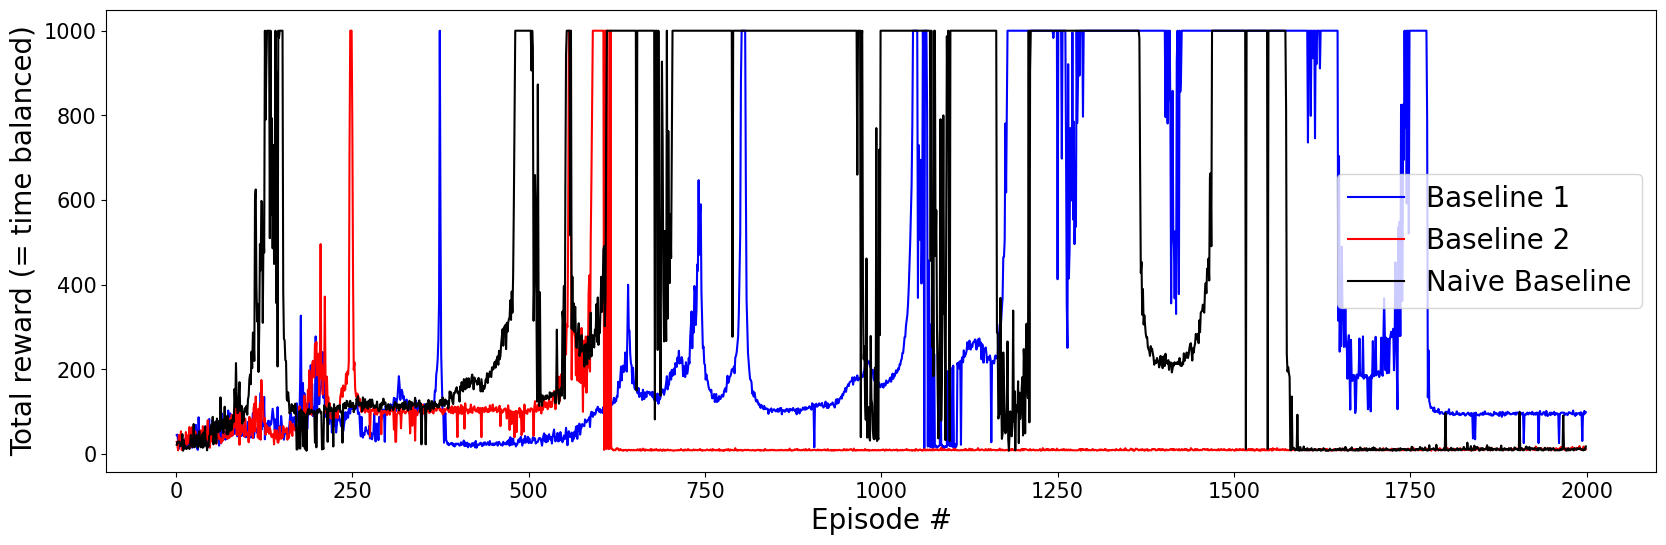

In [12]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
#ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')
ax.plot(np.arange(1, len(scores_naive_baseline) + 1), scores_naive_baseline, color='black', label='Naive Baseline')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()